In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


In [168]:
def make_dataset(data, y_cols, ix = np.arange(0, -10, -1), iy = 2):
    
    '''Making two dataframes X and y. Each row of X is concatenation of rows of original data for 
       shifts defined by ix. Dataframe y has rows of original data taken with shift iy'''

    cols = data.columns
    data_ar = np.array(data)
    y_data_ar = np.array(data[y_cols])
    N = len(data)
    X, y = [], []
    for i in range(-ix[-1], N - iy):
        rows = np.concatenate([data_ar[i + shift] for shift in ix], axis = 0)
        y_row = y_data_ar[i + iy]     
        X.append(rows)
        y.append(y_row)
        
    new_cols = [c + ' %d steps before' % (-i) for i in ix for c in cols]
    X = pd.DataFrame(X, columns = new_cols)
    y = pd.DataFrame(y, columns = y_cols)
    return X, y
    
    
def choose_cols(data, key):
    
    '''Returns list of column names containing key'''
    
    cols = data.columns
    cols_with_key = [c for c in cols if key in c]
    return cols_with_key

def evaluate_parformance(dataframe, cols, y_cols, train_ratio, ix, iy, clf = GradientBoostingRegressor(n_estimators = 228)):
    
    '''Evaluates performance of classifier clf predicting iy steps forward using 
       rows defined by ix to. Prints mean squared error and shows prediction plot'''
    
    X, y = make_dataset(dataframe[cols], y_cols, ix, iy)
    n_train = int(len(X) * train_ratio)
    X_train, y_train = X[ : n_train], y[ : n_train]
    X_test, y_test = X[n_train : ], y[n_train : ]
    clf = GradientBoostingRegressor(n_estimators = 228)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    MSE = mean_squared_error(prediction, y_test)
    #plt.figure(figsize = (17, 9))
    plt.plot(range(len(y_test)), prediction, label = 'prediction')
    plt.plot(range(len(y_test)), y_test, label = 'real data')
    _ = plt.legend()
    print('MSE = %.3f' % MSE)
    return clf, prediction,  X_train, y_train, X_test, y_test

def chain_prediction(clf, dataframe, ix, iy):
    
    '''Predicts whole dataset starting with some real values'''
    data_ar = np.array(dataframe)
    iy_pred = [i for i in range(-ix[-1] + iy, len(dataframe))]
    ix_pred = {y_pred : ix - iy + y_pred for y_pred in iy_pred}
    data_predicted = np.float('inf') * np.ones(data_ar.shape)
    #initial values we use to start predicting
    for y_pred in iy_pred[:iy]:
        for x_pred in ix_pred[y_pred]:
            data_predicted[x_pred] = data_ar[x_pred]
            
    for y_pred in iy_pred:
        x_pred = ix_pred[y_pred]
        row = np.concatenate([data_predicted[x] for x in x_pred]).reshape((1, -1))
        prediction = clf.predict(row)
        data_predicted[y_pred] = prediction
        
    return data_predicted
        

In [157]:
dataframe = pd.read_table('./dataex/dt.txt', sep = ';')
dataframe.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,1,19370101,-999,-999,-999,5,0.0,0,-999,0,6.3,-999.0,-999,-0.5,-999.0,2.5,-1.6,-999.0,eor
1,1,19370102,-999,-999,-999,5,0.0,0,-999,0,3.0,-999.0,-999,0.3,-999.0,5.0,-4.0,-999.0,eor
2,1,19370103,-999,-999,-999,5,0.0,0,-999,0,4.3,-999.0,-999,3.2,-999.0,5.0,-0.2,-999.0,eor
3,1,19370104,-999,-999,-999,5,0.0,0,-999,0,8.0,-999.0,-999,0.2,-999.0,3.8,-0.2,-999.0,eor
4,1,19370105,-999,-999,-999,5,0.0,0,-999,0,8.0,-999.0,-999,1.4,-999.0,4.5,-0.7,-999.0,eor


In [159]:
dataframe.columns

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', '  FX', '  FM', 'QN_4', ' RSK',
       'RSKF', ' SDK', 'SHK_TAG', '  NM', ' VPM', '  PM', ' TMK', ' UPM',
       ' TXK', ' TNK', ' TGK', 'eor'],
      dtype='object')

/home/brain/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE = 11.036


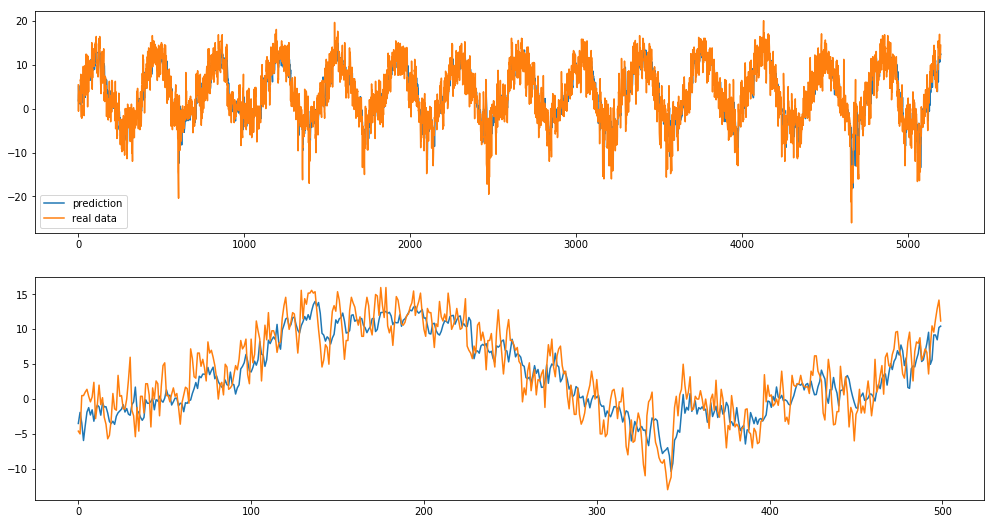

In [165]:
# testing performance of gradientboosting predicting TNK[i + 3] using val[i -25], val[i - 24], ..., val[i] 
# where val goes through the list  COLS. 70% of data is used for training
TRAIN_RATIO = 0.7
COLS = [' TNK', ' TXK', '  NM', ' TMK']
y_cols = [' TNK']
ix = np.arange(0, -25, -1)
iy = 3

plt.figure(figsize = (17, 9))
plt.subplot(211)
clf, prediction, X_train, y_train, X_test, y_test = evaluate_parformance(dataframe, COLS, y_cols, TRAIN_RATIO, ix, iy)

# scoped in plot
plt.subplot(212)

plt.plot(clf.predict(X_train[:500]))
plt.plot(np.array(y_train[:500]))

/home/brain/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE = 12.977


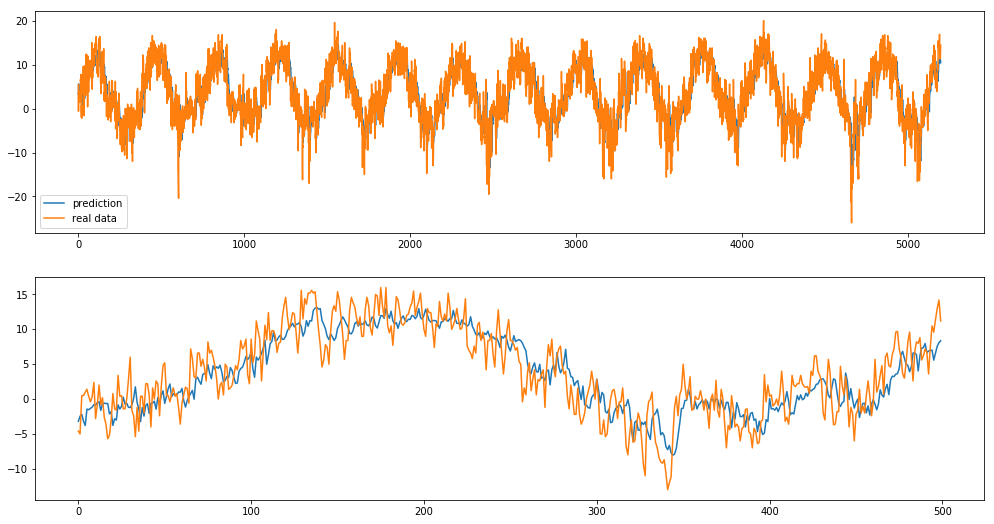

In [166]:
# testing performance of gradientboosting predicting TNK[i + 3] using val[i -25], val[i - 24], ..., val[i] 
# where val goes through the list  COLS. 70% of data is used for training
TRAIN_RATIO = 0.7
COLS = [' TNK']
y_cols = [' TNK']
ix = np.arange(0, -25, -1)
iy = 3

plt.figure(figsize = (17, 9))
plt.subplot(211)
clf, prediction, X_train, y_train, X_test, y_test = evaluate_parformance(dataframe, COLS, y_cols, TRAIN_RATIO, ix, iy)

# scoped in plot
plt.subplot(212)

plt.plot(clf.predict(X_train[:500]))
plt.plot(np.array(y_train[:500]))

MSE is 84.588


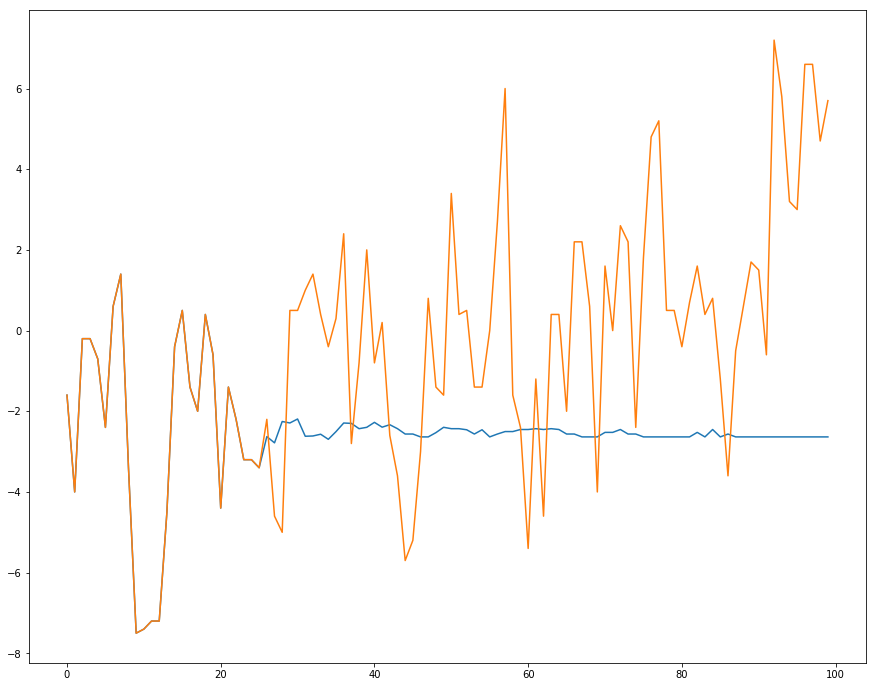

In [169]:
# Testing chain prediction
plt.figure(figsize = (15, 12))
chain_pred =  chain_prediction(clf, dataframe[COLS], ix, iy)
print('MSE is %.3f' % mean_squared_error(a, dataframe[COLS]))
plt.plot(range(100), a[:100])
plt.plot(range(100), dataframe[COLS][:100])

Chain prediction doesnt work at all, one step forward works fine.